In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

def voronoicentroid(x, Q):
    # Compute bounds of the polygon
    Qb = Q.bounds
    Ql = Q.length

    # Create a larger frame around the polygon
    frame = np.array([[Qb[0] - Ql * 10, Qb[1] - Ql * 10],
                    [Qb[2] + Ql * 10, Qb[1] - Ql * 10],
                    [Qb[0] - Ql * 10, Qb[3] + Ql * 10],
                    [Qb[2] + Ql * 10, Qb[3] + Ql * 10]])

    # Append the frame to the original points
    xframe = np.append(x, frame, axis=0)

    # Compute the Voronoi diagram
    vor = Voronoi(xframe)
    # Computation of Voronoi centroids
    vcentroids = np.zeros_like(x)  # Initialize array for centroids

    for i in range(len(x)):
        # Get the vertices of the Voronoi region for the i-th point
        poly = [vor.vertices[v] for v in vor.regions[vor.point_region[i]] if v != -1]
        # Create a Polygon from the vertices
        if len(poly) > 0:
            i_cell = Q.intersection(Polygon(poly))
            if not i_cell.is_empty:
                vcentroids[i] = i_cell.centroid.coords[0]
            else:
                vcentroids[i] = np.nan  # Assign NaN if the intersection is empty
    return vcentroids, vor

/home/kap/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [19]:
from matplotlib import animation
import matplotlib as mpl
def simulate(ref_states_list, cat_states_list, obstacles, cat_controls_list, num_frames, max_iter, N, init_list, vor_list, vcentroid_lists, save=False):
    def create_triangle(state=[0,0,0], h=0.2, w=0.15, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [np.cos(th), -np.sin(th)],
            [np.sin(th),  np.cos(th)]
        ])

        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]


    # Function to create a gradient-filled circle
    def radial_gradient_circle(ax, center_x, center_y, radius, colormap='viridis'):
        """
        Creates a radial gradient circle.
        """

        # Create a meshgrid for the circle
        x, y = np.meshgrid(np.linspace(center_x - radius, center_x + radius, 100),
                        np.linspace(center_y - radius, center_y + radius, 100))

        # Calculate the distance from the center for each point
        r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

        # Normalize the distance to be between 0 and 1
        r = np.clip(r, 0, radius) / radius

        # Create a colormap
        cmap = plt.get_cmap(colormap).reversed()

        # Map the distance to the colormap
        colors = cmap(r)

        # Plot the circle
        ax.imshow(colors, extent=[center_x - radius, center_x + radius, center_y - radius, center_y + radius], alpha=0.1)

        # Set aspect to 'equal' to ensure the circle looks circular
        ax.set_aspect('equal')



    def init():
        return path_list, horizon_list
    
    def animate(i):
        ax.clear()
        for k in range(n_agents):
            # get variables
            x = cat_states_list[k][0, 0, i]
            y = cat_states_list[k][1, 0, i]
            th = cat_states_list[k][2, 0, i]

            # update path
            if i == 0:
                path_list[k].set_data(np.array([]), np.array([]))
            x_new = np.hstack((path_list[k].get_xdata(), x))
            y_new = np.hstack((path_list[k].get_ydata(), y))
            path, = ax.plot(x_new, y_new, 'r', linewidth=2)
           
            # update horizon
            x_new = cat_states_list[k][0, :, i]
            y_new = cat_states_list[k][1, :, i]
            horizon, = ax.plot(x_new, y_new, 'x-g', alpha=0.5)
            
            #current_state_list[k].set_xy(create_triangle([x, y, th], update=True))
            current_triangle = create_triangle([x, y, th])
            current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='b')
            current_state = current_state[0]

            # Draw a transparent circle
            radial_gradient_circle(ax, x, y, radius=1.25, colormap='Greens')

        den = num_frames/max_iter
        # Show Centroids
        for vcentroids in vcentroid_lists[int(i/den)]:
            ax.plot(vcentroids[0], vcentroids[1], 'o', color='blue')

        voronoi_plot_2d(vor_list[int(i/den)], ax=ax, show_vertices=False, show_points = False, line_colors='orange', line_width=2)
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)

        return path, horizon

    # create figure and axes
    n_agents = 5
    fig, ax = plt.subplots(figsize=(6, 6))
    # create lines:
    #   path
    path_list = []
    ref_path_list = []
    horizon_list = []
    current_state_list = []
  
    for k in range(n_agents):
        path, = ax.plot([], [], 'r', linewidth=2)
        ref_path, = ax.plot([], [], 'b', linewidth=2)
        horizon, = ax.plot([], [], 'x-g', alpha=0.5)
        current_triangle = create_triangle(init_list[k, :])
        current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='y')
        current_state = current_state[0]

        path_list.append(path)
        ref_path_list.append(ref_path)
        horizon_list.append(horizon)
        current_state_list.append(current_state)

    
    sim = animation.FuncAnimation(
        fig=fig,
        func = animate,
        init_func=init,
        frames=num_frames,
        interval=100,
        blit=False,
        repeat=False
    )
    if save == True:
        sim.save('heatmap.mp4', writer='ffmpeg', fps=50)
    plt.show()
    return sim


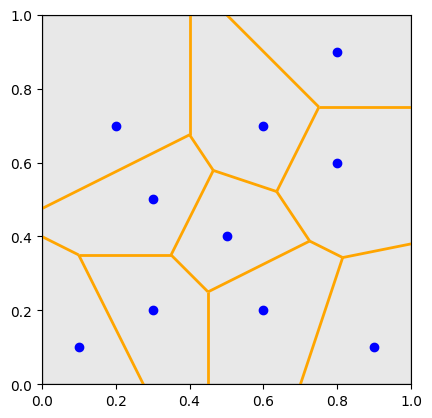

In [4]:
# Define the polygon Q
Q = Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])

# Define the points for the Voronoi diagram
x = np.array([[0.1, 0.1], [0.8, 0.6], [0.2, 0.7], [0.6, 0.2],
            [0.3, 0.2], [0.3, 0.5], [0.9, 0.1], [0.8, 0.9],
            [0.6, 0.7], [0.5, 0.4]])

vcentroids, vor = voronoicentroid(x, Q)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2)

# Plot the original points
ax.plot(x[:, 0], x[:, 1], 'o', color='blue')

# Plot the polygon
x_polygon, y_polygon = Q.exterior.xy
ax.fill(x_polygon, y_polygon, alpha=0.5, fc='lightgray', ec='black')

# Set aspect and limits
plt.gca().set_aspect('equal')
plt.gca().set_xlim([0, 1])
plt.gca().set_ylim([0, 1])
plt.show()


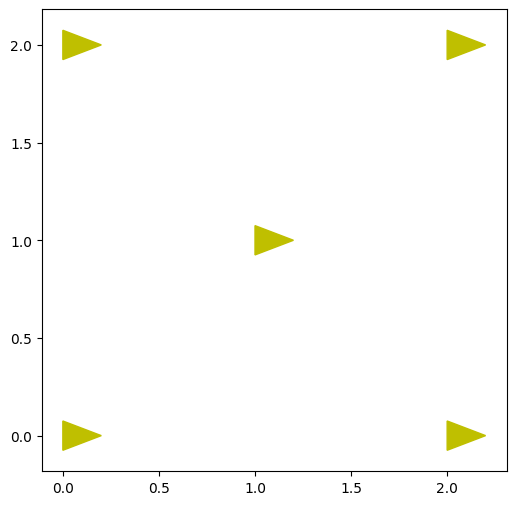

In [20]:
import casadi
from plan_mpc_unicycle import MPC_CBF_Unicycle, dm_to_array


Q_x = 10
Q_y = 10
Q_theta = 10
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20


v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 5

start_list = [[0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1, 1, 0.0], [0.0, 2.0, 0.0], [2.0, 2.0, 0.0]]


t0_list = [0 for i in range(n_agents)]
agents = [MPC_CBF_Unicycle(dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False) for i in range(n_agents)]
ref_states_list = []


state_0_list = [casadi.DM([start_list[i][0], start_list[i][1], start_list[i][2]]) for i in range(n_agents)]
u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
cat_states_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
cat_controls_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]

vor_list = []
vcentroids_list = []

p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
vcentroids, vor = voronoicentroid(p, workspace)
vor_list.append(vor)
vcentroids_list.append(vcentroids)    

max_iter = 20
max_time = 20
for k in range(max_iter):
    ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]
    for t in range(max_time):
        #print(ref_states_list)
        for j in range(n_agents):
            u, X_pred = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t)
            cat_states_list[j] = np.dstack((cat_states_list[j], dm_to_array(X_pred)))
            cat_controls_list[j] = np.dstack((cat_controls_list[j], dm_to_array(u[:, 0])))
            t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred, u)
    p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    


# Visualization    
from IPython.display import HTML
num_frames = max_iter*max_time
sim = simulate(ref_states_list, cat_states_list, None, cat_controls_list, num_frames, max_iter, N,
         np.array(start_list), vor_list, vcentroids_list, save=False)
HTML(sim.to_html5_video())  

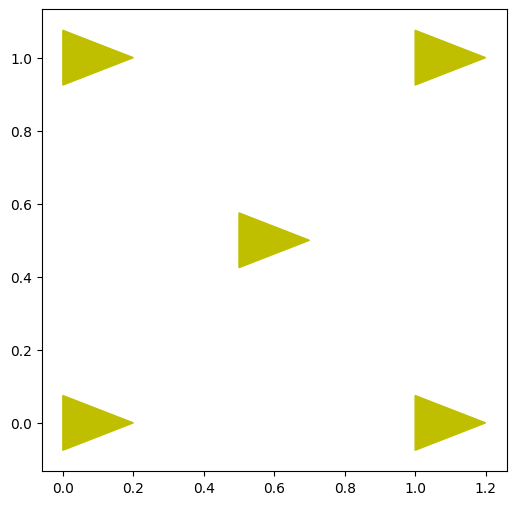

In [15]:
import casadi
from plan_mpc_unicycle import MPC_CBF_Unicycle, dm_to_array


Q_x = 10
Q_y = 10
Q_theta = 10
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20


v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 5

start_list = [[0.0, 0.0, 0.0], [1.0, 0.0, 0.0],  [0.5, 0.5, 0.0], [0.0, 1.0, 0.0], [1.0, 1.0, 0.0]]


t0_list = [0 for i in range(n_agents)]
agents = [MPC_CBF_Unicycle(dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False) for i in range(n_agents)]
ref_states_list = []


state_0_list = [casadi.DM([start_list[i][0], start_list[i][1], start_list[i][2]]) for i in range(n_agents)]
u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
cat_states_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
cat_controls_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]

vor_list = []
vcentroids_list = []

p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
vcentroids, vor = voronoicentroid(p, workspace)

for k in range(20):
   
    ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]
    for t in range(30):
        #print(ref_states_list)
        for j in range(n_agents):
            if j==2 and k>1:
                u, X_pred = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t)
                cat_states_list[j] = np.dstack((cat_states_list[j], dm_to_array(X_pred)))
                cat_controls_list[j] = np.dstack((cat_controls_list[j], dm_to_array(u[:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred, casadi.DM.zeros((agents[j].n_controls, N)))
            else:
                u, X_pred = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t)
                cat_states_list[j] = np.dstack((cat_states_list[j], dm_to_array(X_pred)))
                cat_controls_list[j] = np.dstack((cat_controls_list[j], dm_to_array(u[:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred, u)
    p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    


# Visualization    
from IPython.display import HTML
num_frames = 20*30
sim = simulate(ref_states_list, cat_states_list, None, cat_controls_list, num_frames, N,
         np.array(start_list), vor_list, vcentroids_list, save=False)
HTML(sim.to_html5_video())  